In [56]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [57]:
class LeafImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, train=True, transform=None, target_trainsform=None):
        self.img_labels = pd.read_csv(annotations_file)

        if train:
            unique_label = self.img_labels['label'].unique()
            self.label_mapping = {label: i for i, label in enumerate(unique_label)}
        for i in range(len(self.img_labels)):
            self.img_labels.loc[i, 'labeli']= self.label_mapping[self.img_labels.loc[i, 'label']] 
        
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_trainsform
        self.train = train

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        if self.train:
            label = self.img_labels.iloc[idx, 1]
            labeli = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label, labeli
    

In [58]:
LeafTrain = LeafImageDataset('./train.csv', '')

In [59]:
imaget,labelt, labelti = LeafTrain.__getitem__(7)

In [60]:
imaget.shape

torch.Size([3, 224, 224])

label of the image: broussonettia_papyrifera


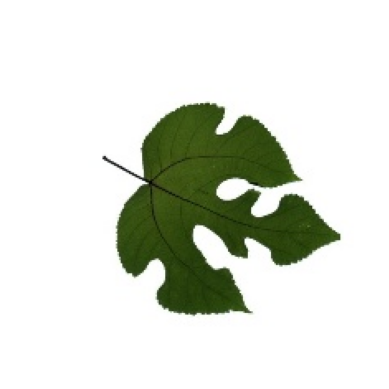

In [61]:
plt.imshow(imaget.permute(1,2,0))
plt.axis('off')
print(f'label of the image: {labelt}')

In [62]:
LeafTest = LeafImageDataset('./test.csv','')

KeyError: 'label'

In [ ]:
# Generate a dict for the labels in the train

Leaf_mapping = LeafTrain.label_mapping
Leaf_mapping

{'maclura_pomifera': 0,
 'ulmus_rubra': 1,
 'broussonettia_papyrifera': 2,
 'prunus_virginiana': 3,
 'acer_rubrum': 4,
 'cryptomeria_japonica': 5,
 'staphylea_trifolia': 6,
 'asimina_triloba': 7,
 'diospyros_virginiana': 8,
 'tilia_cordata': 9,
 'ulmus_pumila': 10,
 'quercus_muehlenbergii': 11,
 'juglans_cinerea': 12,
 'cercis_canadensis': 13,
 'ptelea_trifoliata': 14,
 'acer_palmatum': 15,
 'catalpa_speciosa': 16,
 'abies_concolor': 17,
 'eucommia_ulmoides': 18,
 'quercus_montana': 19,
 'koelreuteria_paniculata': 20,
 'liriodendron_tulipifera': 21,
 'styrax_japonica': 22,
 'malus_pumila': 23,
 'prunus_sargentii': 24,
 'cornus_mas': 25,
 'magnolia_virginiana': 26,
 'ostrya_virginiana': 27,
 'magnolia_acuminata': 28,
 'ilex_opaca': 29,
 'acer_negundo': 30,
 'fraxinus_nigra': 31,
 'pyrus_calleryana': 32,
 'picea_abies': 33,
 'chionanthus_virginicus': 34,
 'carpinus_caroliniana': 35,
 'zelkova_serrata': 36,
 'aesculus_pavi': 37,
 'taxodium_distichum': 38,
 'carya_tomentosa': 39,
 'picea_p

In [ ]:
# Lenet baseline
net = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels= 64, kernel_size=11, padding=2, stride=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 3, stride=2),
        nn.Flatten(),
        nn.Linear(12800,1024), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(1024,1024), 
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(1024, 175)  
)

In [ ]:
Xt= torch.randn(1,3,224,224)
for layer in net:
    Xt=layer(Xt)
    print(layer.__class__.__name__, 'output shape:\t', Xt.shape)

Conv2d output shape:	 torch.Size([1, 64, 109, 109])
ReLU output shape:	 torch.Size([1, 64, 109, 109])
MaxPool2d output shape:	 torch.Size([1, 64, 54, 54])
Conv2d output shape:	 torch.Size([1, 128, 50, 50])
ReLU output shape:	 torch.Size([1, 128, 50, 50])
MaxPool2d output shape:	 torch.Size([1, 128, 25, 25])
Conv2d output shape:	 torch.Size([1, 128, 21, 21])
ReLU output shape:	 torch.Size([1, 128, 21, 21])
MaxPool2d output shape:	 torch.Size([1, 128, 10, 10])
Flatten output shape:	 torch.Size([1, 12800])
Linear output shape:	 torch.Size([1, 1024])
ReLU output shape:	 torch.Size([1, 1024])
Dropout output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 1024])
ReLU output shape:	 torch.Size([1, 1024])
Dropout output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 175])


In [ ]:
# Build a cross val with Resnet with train data
from sklearn.model_selection import KFold

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()


k = 5
num_epochs = 1
batch_size = 64

splits = KFold(n_splits=k, shuffle=True, random_state=42)


In [66]:
# Train and Eval functions
def train_epoch(model, device, dataloader, loss_f, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()

    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_f(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * image.size(0)
        score, prediction = torch.max(output.data, 1)
        train_correct += (prediction == label).sum().item()

    return train_loss, train_correct

def valid_epoch(model, device, dataloader, loss_f):
    val_loss, val_correct, = 0.0, 0
    model.eval()
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_f(output, label)
            valid_loss += loss.item() * image.size(0)
            score, prediction = torch.max(output.data, 1)
            val_correct += (prediction == label).sum().item()

    return val_loss, val_correct

In [67]:
# Model train and eval

history = {'train_loss': [], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for fold, (train_idx, val_idx), in enumerate(splits.split(np.arange(len(LeafTrain)))):
    print(f'Fold {fold+1}')

    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(LeafTrain, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(LeafTrain, batch_size=batch_size, sampler=val_sampler)

    model = net
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.002)

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer)
        val_loss, val_correct=valid_epoch(model,device,val_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        val_loss = val_loss / len(val_loader.sampler)
        val_acc = val_correct / len(val_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1, num_epochs,
                                                                                                                                train_loss,
                                                                                                                                val_loss,
                                                                                                                                train_acc,
                                                                                                                                val_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(val_acc)   

Fold 1


TypeError: list indices must be integers or slices, not str